# Reverse Cuthill-Mckee Algorithm [(George, Liu, 1994)](https://eva.fing.edu.uy/pluginfile.php/316033/mod_resource/content/1/Computer%20Solution%20of%20Sparse%20Linear%20Systems.pdf)

In [45]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from scipy.sparse import random


np.random.seed(2023)

def matrix2graph(matrix:np.array, visualize=False):
    """
    convert matrix into graph
    :param matrix: positive definite (PD) matrix 
    :return: an undirected graph
    """
    G = nx.Graph()
    # add nodes
    n = matrix.shape[0]
    nodes = range(n)
    G.add_nodes_from(nodes)
    # add edge
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i,j] != 0:
                G.add_edge(i, j)
    # visualize
    if visualize:
        nx.draw(G, with_labels=True)
    return G

def mesh_matrix(g_size:int) -> np.array:
    """
    create mesh-like (planar) PD matrix, 
    :param g_size: size of the related graph
    :return: positive definite matrix
    """
    # matrix width
    m_size = g_size**2 
    mx = np.identity(m_size)*10
    for i in range(m_size):
        if (i+1) % g_size == 1:
            mx[i][i+1] = 1
        elif (i+1) % g_size == 0:
            mx[i][i-1] = 1
        else:
            mx[i][i-1] = 1
            mx[i][i+1] = 1
    j = 0
    for i in range(g_size, m_size):
        mx[i][j] = 1
        mx[j][i] = 1
        j += 1
    return mx


def random_m(size, density=0.02, visualize=False):
    """
    generate a sparse random matrix
    """
    # generate a random sparse matrix
    S = random(size, size, density=density, format='csr') 
    S = np.dot(S.T,S)
    S = S + 0.1*np.identity(size) 
    if visualize:
        plt.figure()
        plt.spy(S.A)
    return S




def level_set_algo(G, root) -> list:
    """
    find the level set with respect to a root vertex
    :param G: Networkx undirected graph
    :param root: root vertex, the starting point
    :return: level set, ordered by distance
    """

    pathes = nx.single_source_shortest_path(G,root)
    pathes_length = [len(route) - 1 for route in pathes.values()]
    pathes_nodes = list(pathes.keys())
    level_set = []
    for i, vertex in enumerate(pathes_nodes):
        if pathes_length[i] == pathes_length[i-1]:
            level_set[-1].append(vertex)
        else:
            level_set.append([vertex])
    
    return level_set


def diameter_pair_algo(G) -> set:
    """
    pseudo-peripheral algorithsm (George, Liu, 1994)
    
    find one pseudo-diameter pair
    :param G: Networkx undirected graph
    :return: a pair of mutual-extremal vertexes (s,t)
    """
    s = np.random.choice(G.nodes)
    while True:
        level_set_s = level_set_algo(G,s)
        # choose a node in the last level set of minimum degree
        nodes = [(i,G.degree[i]) for i in level_set_s[-1]]
        t = min(nodes, key = lambda x: x[1])[0]
        level_set_t = level_set_algo(G,t)
        if len(level_set_t) > len(level_set_s):
            s = t
        return t
        
def subGraphs(G) -> list:
    """
    find all connected components of the graph
    :param G: Networkx undirected graph
    :return: a list of connected graphes
    """
    comps = nx.connected_components(G)
    # the last subgraph is the biggest one
    comps = sorted(list(comps), key = len)
    sub_graphs = [G.subgraph(nodes).copy() for nodes in comps]
    return sub_graphs


def permute(mtrx, p):
    """
    permute the matrix
    """
    I = np.identity(mtrx.shape[0])
    I = I[p]
    return I@mtrx@I.T




def RCM(G):
    """
    RCM algorithm
    """
    def single_seach(G):
        # Breadth first search
        root = diameter_pair_algo(G)
        que = deque()
        que.append(root)

        visited = [root]

        while que:
            for _ in range(len(que)):
                root = que.popleft()
                adjacencies = G.adj[root].keys()
                subsidiaries = [node for node in adjacencies if node not in visited]
                for sub in subsidiaries:
                    que.append(sub)
                    visited.append(sub)

        return visited[::-1]
    
    reordered = []
    sub_graphes = subGraphs(G)
    for sub_graph in sub_graphes:
        if len(list(sub_graph.nodes)) <= 1:
            reordered += list(sub_graph.nodes) 
        else:
            reordered += single_seach(sub_graph)
    return reordered


## Test case 1:
Toy

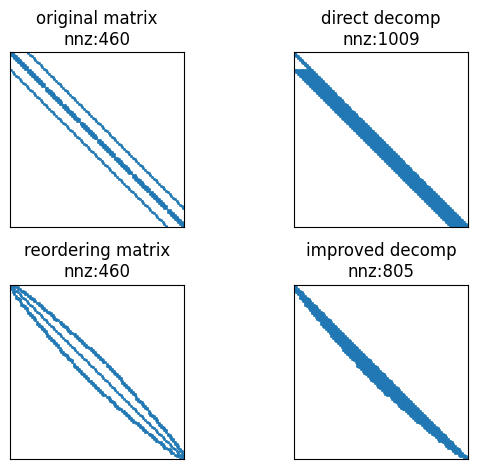

In [46]:
np.random.seed(10)
# test case 1
mtrix = mesh_matrix(10)
G = matrix2graph(mtrix,False)
p = RCM(G)
new_mtrix = permute(mtrix,p)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

L = np.linalg.cholesky(mtrix)
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))
ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

L_ = np.linalg.cholesky(new_mtrix)
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()

## Test case 2

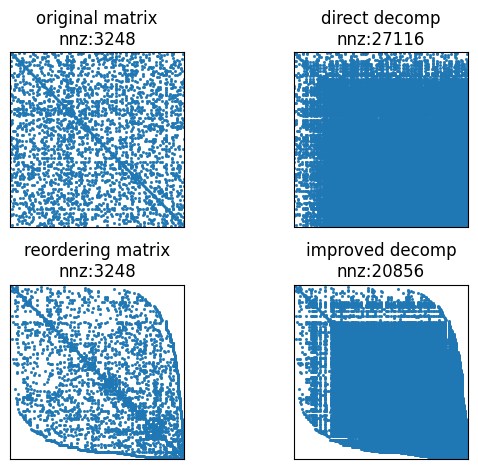

In [47]:
np.random.seed(2023)

mtrix = random_m(200)
G = matrix2graph(mtrix)
p = RCM(G)

# permutation
I = np.identity(mtrix.shape[0])
I = I[p]
new_mtrix = I@mtrix@I.T



fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

L = np.linalg.cholesky(mtrix)
L = L+L.T
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))

ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

L_ = np.linalg.cholesky(new_mtrix)
L_ += L_.T
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()

## Test case 3

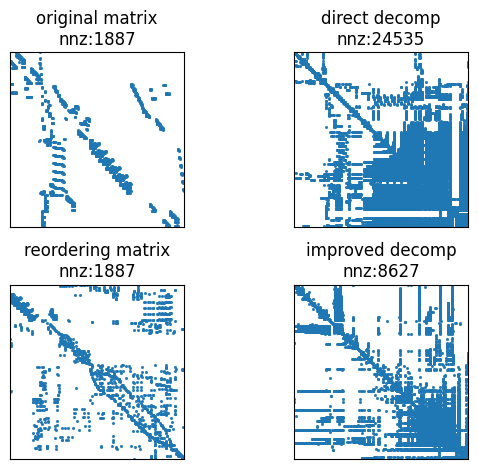

In [48]:
import scipy.io
import numpy as np
from scipy.linalg import lu

mtrix = scipy.io.loadmat('./TestData/matrix.mat')['west0479'].toarray()

G = matrix2graph(mtrix,False)
p = RCM(G)
new_mtrix = permute(mtrix,p)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.spy(mtrix, markersize=1)
ax1.set_title("original matrix\nnnz:{}".format(np.count_nonzero(mtrix)))

# L = np.linalg.cholesky(mtrix)
_, L, _ = lu(mtrix)
L += L.T
ax2.spy(L, markersize=1)
ax2.set_title("direct decomp\nnnz:{}".format(np.count_nonzero(L)))
ax3.spy(new_mtrix, markersize=1)
ax3.set_title("reordering matrix\nnnz:{}".format(np.count_nonzero(new_mtrix)))

# L_ = np.linalg.cholesky(new_mtrix)
_, L_, _ = lu(new_mtrix)
L_ += L_.T
ax4.spy(L_, markersize=1)
ax4.set_title("improved decomp\nnnz:{}".format(np.count_nonzero(L_)))
# fig.autofmt_xdate()
ax1.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax2.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax3.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
ax4.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False, top=False,labeltop=False)
plt.tight_layout()

## Existing issues
- How to deal with single nodes?